## <b> Capstone Project: Predicting future electricity stock market prices <b>

    
## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Methodology](#methodology)
* [4. Analysis](#analysis)
* [5. Results and Discussion](#results)


## 1. Introduction: Business Problem <a name="introduction"></a>

In Germany electricity consumers with very high demand, like big industrial plants, or electricity producer deal their electricity, in contrast to private people, on the stock exchange for electricity exchange (EPEX, European Power Exchange). The most interesting stock exchange for electricity is the Day Ahead Market, where the electricity is marketed for the following day. That is why, the profitability of such business models can be increased if one has a reliable forecast of exchange electricity prices for the next day.

That's where our Data Science skills are needed. In the context of this work we try to find out, if we can explain the current electricity price in dependence of the current electricity demand and production in Germany.
In a further step we also try to forecast the stock market prices for the next 24h. Since the forecasts for the production and demand are quite accurate, we take the future production and demand as given and use them for our prediction.

## 2. Data <a name="data"></a>

### 2.1 Data Sources

All data we need we find at the web portal SMARD from the Germanys Federal Network Agency (https://www.smard.de). In regard to our business problem, we need following data for our analysis: electricity stock market prices, electricity demand and production. We can download these data for the period from 2016 until now via the link below. Notice that the demand and production have a resolution of 15 minutes and the prices of 1 hour.


(https://www.smard.de/home/downloadcenter/download_marktdaten/726#!?downloadAttributes=%7B%22selectedCategory%22:5,%22selectedSubCategory%22:17,%22selectedRegion%22:%22DE%22,%22from%22:1514761200000,%22to%22:1546297199999,%22selectedFileType%22:%22CSV%22%7D)


### 2.2 Load Data

First we install and import necessary libaries for the ETL process:


In [0]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot') # optional: for ggplot-like style
import seaborn as sns

import datetime

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Next we load the data from the disk, merge the data and transfer them into pandas DataFrames.

In [0]:
elec_prices=pd.read_csv('Gro_handelspreise_201601010000_201712312359_1.csv', header=0, sep=';').append(pd.read_csv('Gro_handelspreise_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Gro_handelspreise_201901010000_202005292359_1.csv', header=0, sep=';'))).reset_index(drop=True)
elec_demand=pd.read_csv('Realisierter_Stromverbrauch_201601010000_201712312345_1.csv', header=0, sep=';').append(pd.read_csv('Realisierter_Stromverbrauch_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Realisierter_Stromverbrauch_201901010000_202005292345_1.csv', header=0,sep=';'))).reset_index(drop=True)
elec_supply=pd.read_csv('Realisierte_Erzeugung_201601010000_201712312345_1.csv', header=0, sep=';').append(pd.read_csv('Realisierte_Erzeugung_201801010000_201812312359_1.csv', header=0, sep=';').append(pd.read_csv('Realisierte_Erzeugung_201901010000_202005292345_1.csv', header=0, sep=';'))).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



### 2.2 Data Exploration, Cleaning and Wrangling


Data quality:
As expected for a federal agency dataset the quality is perfect and there are no missing or wrong values.

Cause the market area in Germany changed in the inspected time, we have to merge the columns 'Deutschland/Luxemburg[€/MWh]' and 'Deutschland/Österreich/Luxemburg[€/MWh]' to only one price column. This and some other data wrangling tasks and the merge of all data into one DataFrame we solve in the next lines:

In [0]:
# New Datetime Column
elec_supply['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='15Min')
elec_demand['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='15Min')
elec_prices['Datetime']=pd.date_range(start='01/01/2016 00:00:00', end='05/29/2020 23:45:00', freq='60Min')

# delete old Date Column
elec_supply.drop(columns=['Datum', 'Uhrzeit'],inplace =True)
elec_demand.drop(columns=['Datum', 'Uhrzeit'],inplace =True)
elec_prices.drop(columns=['Datum', 'Uhrzeit'],inplace =True)

# Rearange the Columns 
elec_supply_col_names=['Datetime','Biomasse[MWh]', 'Wasserkraft[MWh]', 'Wind Offshore[MWh]',
        'Wind Onshore[MWh]', 'Photovoltaik[MWh]', 'Sonstige Erneuerbare[MWh]',
        'Kernenergie[MWh]', 'Braunkohle[MWh]', 'Steinkohle[MWh]', 'Erdgas[MWh]',
        'Pumpspeicher[MWh]', 'Sonstige Konventionelle[MWh]']
elec_demand_col_names=['Datetime','Gesamt[MWh]']
elec_prices_col_names=['Datetime','Deutschland/Luxemburg[€/MWh]','Deutschland/Österreich/Luxemburg[€/MWh]']

elec_supply=elec_supply[elec_supply_col_names]
elec_demand=elec_demand[elec_demand_col_names]
elec_prices=elec_prices[elec_prices_col_names]


# Wrangling the elec_prices dataframe 
elec_prices.replace("-", "0", inplace = True)
#for i in range(1,len(elec_prices_col_names)):
 #   elec_prices[elec_prices_col_names[i]] = [x.replace(".", "") for x in elec_prices[elec_prices_col_names[i]]]
  #  elec_prices[elec_prices_col_names[i]] = [x.replace(",", ".") for x in elec_prices[elec_prices_col_names[i]]]

elec_supply.replace("-", "0", inplace = True)
#for i in range(1,len(elec_supply_col_names)):
 #   elec_supply[elec_supply_col_names[i]] = [str(x).replace(".", "") for x in elec_supply[elec_supply_col_names[i]]]
  #  elec_supply[elec_supply_col_names[i]] = [str(x).replace(",", ".") for x in elec_supply[elec_supply_col_names[i]]]

elec_demand.replace("-", "0", inplace = True)
#for i in range(1,len(elec_demand_col_names)):
 #   elec_demand[elec_demand_col_names[i]] = [str(x).replace(".", "") for x in elec_demand[elec_demand_col_names[i]]]
  #  elec_demand[elec_demand_col_names[i]] = [str(x).replace(",", ".") for x in elec_demand[elec_demand_col_names[i]]]
    
# Convert to float
elec_supply[elec_supply_col_names[1:]]=elec_supply[elec_supply_col_names[1:]].astype('float')
elec_demand[elec_demand_col_names[1:]]=elec_demand[elec_demand_col_names[1:]].astype('float')
elec_prices[elec_prices_col_names[1:]]=elec_prices[elec_prices_col_names[1:]].astype('float')

# Cause the market area in Germany changed in the inspected time, we introduce one only price column 
elec_prices['price[€/MWh]']=elec_prices[elec_prices_col_names[1:]].sum(axis=1)
elec_prices.drop(columns=['Deutschland/Luxemburg[€/MWh]','Deutschland/Österreich/Luxemburg[€/MWh]'],inplace =True)


# Reduce resolution of dataframes from 15min to 60min, so that it fits to the price dataframe
a=[]
[a.append(tm - datetime.timedelta(minutes=tm.minute % 60)) for x,tm in enumerate(elec_supply.iloc[:,0])] 
elec_supply['Datetime']=a
elec_demand['Datetime']=a

elec_supply=elec_supply.groupby('Datetime').sum().reset_index()
elec_demand=elec_demand.groupby('Datetime').sum().reset_index()

# Merge the supply anf demand dataframes
elec_sdp = elec_supply.join(elec_demand.set_index('Datetime'), on='Datetime')
#Feature Engineering
#elec_sdp['Import/Export[MWh]']=elec_sdp.iloc[:,1:-2].sum(axis=1)-elec_sdp['Gesamt[MWh]']

# Merge with the price dataframe
elec_sdp=elec_sdp.join(elec_prices.set_index('Datetime'), on='Datetime')

# Next we have to delete the column "Pumpspeicher" ("Pump storage"), cause we suppose that we only can predict the amount of renewable energies in the grid.
elec_sdp.drop(columns=['Pumpspeicher[MWh]'],inplace =True)


Here we can take a look into the merged dataset:

In [0]:
elec_sdp.head()

,Datetime,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
0,2016-01-01 00:00:00,4666.0,1038.0,2276.0,6372.0,0.0,176.0,10706.0,14720.0,4849.0,1931.0,3289.0,41905.0,23.86
1,2016-01-01 01:00:00,4660.0,1032.0,2287.0,6294.0,0.0,176.0,10702.0,14793.0,4128.0,1935.0,3201.0,40127.0,22.39
2,2016-01-01 02:00:00,4651.0,1029.0,2229.0,6313.0,0.0,176.0,10604.0,14856.0,3884.0,1935.0,2952.0,38429.0,20.59
3,2016-01-01 03:00:00,4657.0,1017.0,2011.0,6430.0,0.0,176.0,10684.0,14954.0,3670.0,1925.0,2823.0,37485.0,16.81
4,2016-01-01 04:00:00,4641.0,998.0,1944.0,6352.0,0.0,176.0,10608.0,14931.0,3657.0,1943.0,2598.0,37150.0,17.41


In [0]:
elec_sdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38664 entries, 0 to 38663
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Datetime                      38664 non-null  datetime64[ns]
 1   Biomasse[MWh]                 38664 non-null  float64       
 2   Wasserkraft[MWh]              38664 non-null  float64       
 3   Wind Offshore[MWh]            38664 non-null  float64       
 4   Wind Onshore[MWh]             38664 non-null  float64       
 5   Photovoltaik[MWh]             38664 non-null  float64       
 6   Sonstige Erneuerbare[MWh]     38664 non-null  float64       
 7   Kernenergie[MWh]              38664 non-null  float64       
 8   Braunkohle[MWh]               38664 non-null  float64       
 9   Steinkohle[MWh]               38664 non-null  float64       
 10  Erdgas[MWh]                   38664 non-null  float64       
 11  Sonstige Konventionelle[MWh]

In [0]:
elec_sdp.describe()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
count,38664.000000,38664.00000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000,38664.000000
mean,4608.586521,1828.10394,2189.122924,10148.058950,4445.408649,161.088222,8271.088519,13390.349919,7191.289054,4353.215937,2969.509647,56016.250854,35.089916
std,302.005603,406.50955,1591.956677,8305.153169,6871.460769,33.595066,1466.460544,3515.534232,4512.814155,2501.569410,2416.167631,10004.271728,17.285624
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31307.000000,-130.090000
25%,4437.000000,1535.25000,757.500000,3803.187500,0.000000,135.000000,7370.812500,11801.000000,3090.000000,2368.000000,1129.000000,47629.000000,26.010000
50%,4658.000000,1790.75000,2007.500000,7681.000000,117.000000,158.000000,8413.750000,14542.000000,6426.000000,3724.000000,1411.000000,55578.000000,34.740000
75%,4801.750000,2080.75000,3372.000000,14095.625000,6965.125000,184.000000,9308.750000,15849.000000,10665.250000,5932.000000,4658.250000,64866.500000,44.382500
max,5114.000000,3139.00000,6901.000000,40753.000000,32674.000000,244.000000,10800.000000,19169.000000,19143.000000,14475.000000,19933.000000,77549.000000,163.520000


Let's do some data visualization to get more familiar with the data set.
First we make a bar chart to visualize the energy generation per year. Therefore, we have to normalize our dataset to one year. 

In [0]:
# First we need the number of days of our dataset: 880 days
elec_sdp['Datetime'].max()-elec_sdp['Datetime'].min()

Timedelta('1610 days 23:00:00')

In [0]:
# Normalization and convert  from MWh to TWh
elec_supply_peryear=elec_sdp.iloc[:,1:-2].sum()/1000000/880*365

Here you can see the energy generation for each producer type for one  year:

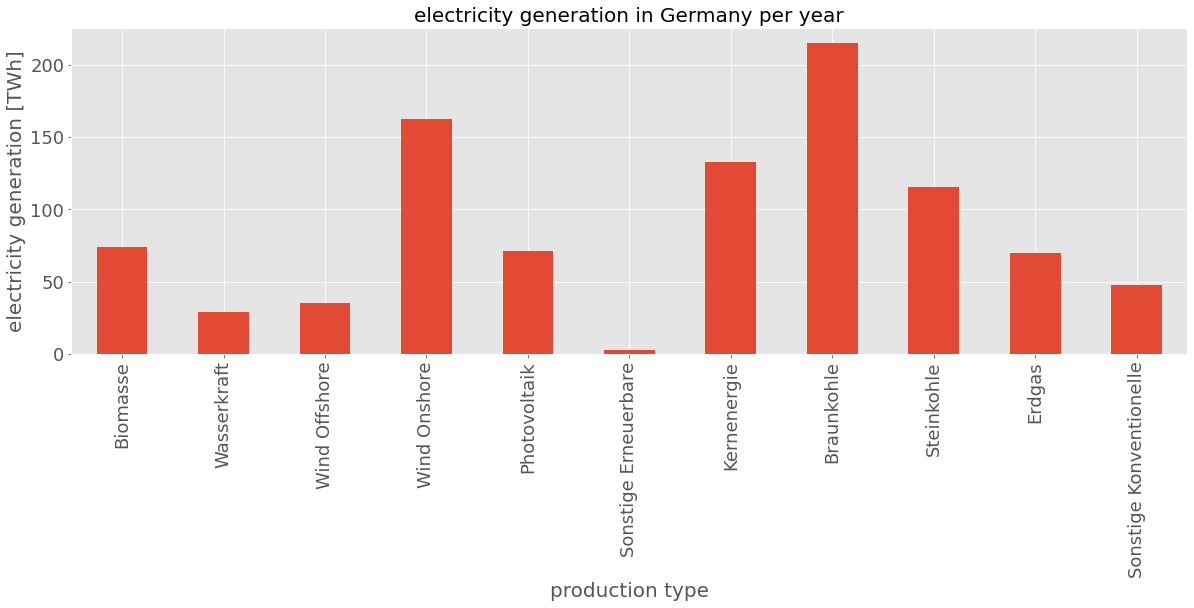

In [0]:
elec_supply_peryear.index=['Biomasse', 'Wasserkraft', 'Wind Offshore',
       'Wind Onshore', 'Photovoltaik', 'Sonstige Erneuerbare',
       'Kernenergie', 'Braunkohle', 'Steinkohle', 'Erdgas',
       'Sonstige Konventionelle']

elec_supply_peryear.plot(kind='bar', figsize=(20, 6), rot=90,fontsize=18) 

plt.xlabel('production type', fontsize=20)
plt.ylabel('electricity generation [TWh]', fontsize=20)
plt.title('electricity generation in Germany per year', fontsize=20)

plt.show()

Now let's check how high is the amount of renewable energy:

In [0]:
elec_supply_RE_Konv_peryear=[elec_supply_peryear[0:6].sum(),elec_supply_peryear[6:].sum()]
elec_supply_RE_Konv_peryear/elec_supply_peryear.sum()
#elec_supply_RE_Konv_peryear=pd.DataFrame({"renewable energy": [elec_supply_RE_Konv_peryear[0]],"fossil energy": [elec_supply_RE_Konv_peryear[1]]})

array([0.39257907, 0.60742093])

So more than 40% of the generated energy in Germany is from renewable energy sources. Hopefully it becomes more and more.

Since the price column is our label, we visualize it:

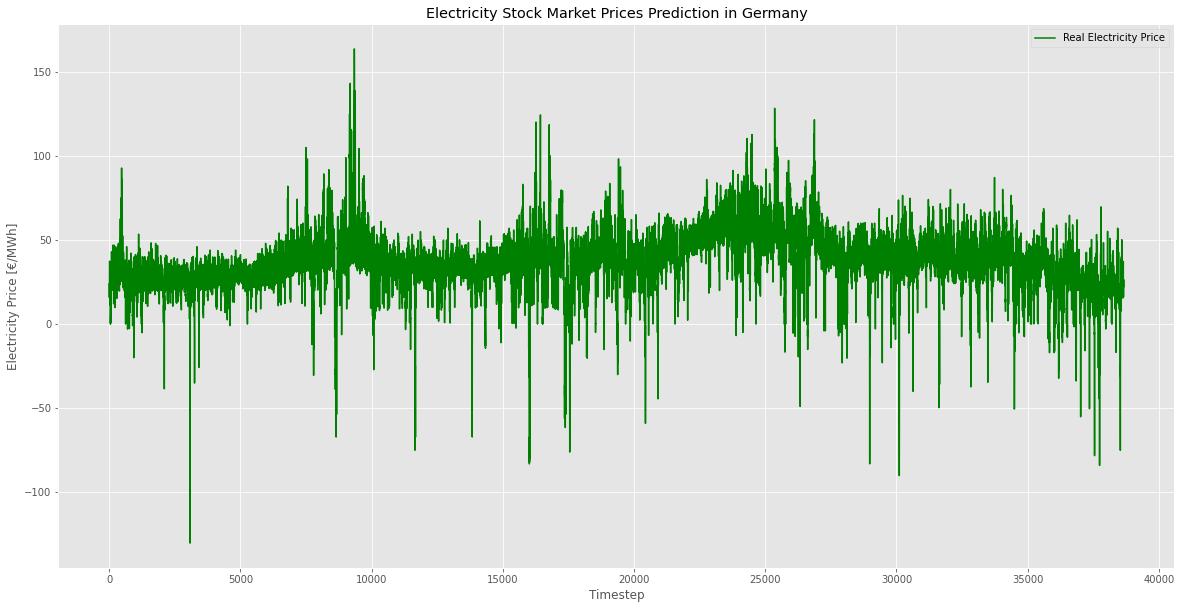

In [0]:
plt.figure(figsize=(20,10))
plt.plot(elec_sdp['price[€/MWh]'], color = 'green', label = 'Real Electricity Price')
plt.title('Electricity Stock Market Prices Prediction in Germany')
plt.xlabel('Timestep')
plt.ylabel('Electricity Price [€/MWh]')
plt.legend()
plt.show()

Next we investigate the distriution of the prices by creating a histogram:

[    1     0     1     4    38    38    32    26    54    95   374  1657
  4559 12083 11290  5521  1810   729   222    67    33    19     5     4
     2]
[-130.09   -118.3456 -106.6012  -94.8568  -83.1124  -71.368   -59.6236
  -47.8792  -36.1348  -24.3904  -12.646    -0.9016   10.8428   22.5872
   34.3316   46.076    57.8204   69.5648   81.3092   93.0536  104.798
  116.5424  128.2868  140.0312  151.7756  163.52  ]


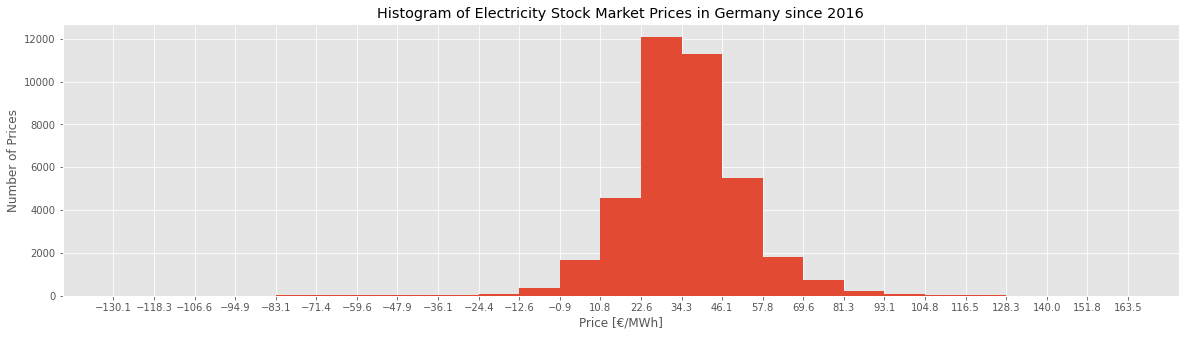

In [0]:
count, bin_edges = np.histogram(elec_sdp[ 'price[€/MWh]' ],bins=25)

print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

elec_sdp[ 'price[€/MWh]' ].plot(kind='hist', figsize=(20, 5), bins=25,xticks=bin_edges)

plt.title('Histogram of Electricity Stock Market Prices in Germany since 2016') # add a title to the histogram
plt.ylabel('Number of Prices') # add y-label
plt.xlabel('Price [€/MWh]') # add x-label

plt.show()

Furthermore we calculate the standard deviation, the skew and the kurtosis:

In [0]:
print('Standard deviation of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].std())
print('Skew of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].skew())
print('Kurtosis of the price distribution: ', elec_sdp[ 'price[€/MWh]' ].kurtosis())

Standard deviation of the price distribution:  17.285623762487205
Skew of the price distribution:  -0.3600558195870197
Kurtosis of the price distribution:  5.503093737706724


Seems that the price values are relative good normally distributed, but the price vector is very volatile.

Now we want to figure out the impact of the features on the price. Therefore, we create a correlation matrix:

In [0]:
elec_sdp.corr()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Sonstige Konventionelle[MWh],Gesamt[MWh],price[€/MWh]
Biomasse[MWh],1.000000,-0.161062,0.257260,0.263409,-0.104105,0.465153,0.111806,-0.018420,0.056061,0.243752,-0.025482,0.112034,-0.010666
Wasserkraft[MWh],-0.161062,1.000000,-0.293893,-0.272504,0.207833,-0.346365,-0.091929,0.009219,-0.085411,-0.263733,-0.000812,-0.112499,-0.152870
Wind Offshore[MWh],0.257260,-0.293893,1.000000,0.677204,-0.141301,0.133658,-0.071207,-0.401991,-0.362326,0.064585,-0.262785,0.071688,-0.212894
Wind Onshore[MWh],0.263409,-0.272504,0.677204,1.000000,-0.181488,0.135274,-0.046084,-0.480681,-0.417544,-0.110412,-0.187684,0.100794,-0.398994
Photovoltaik[MWh],-0.104105,0.207833,-0.141301,-0.181488,1.000000,-0.156433,-0.202851,-0.120630,-0.077544,-0.044000,-0.088322,0.298470,-0.092240
Sonstige Erneuerbare[MWh],0.465153,-0.346365,0.133658,0.135274,-0.156433,1.000000,0.164044,0.267543,0.216529,0.136330,0.251001,0.240628,0.060311
Kernenergie[MWh],0.111806,-0.091929,-0.071207,-0.046084,-0.202851,0.164044,1.000000,0.427975,0.328495,0.075057,0.279384,0.165024,0.195976
Braunkohle[MWh],-0.018420,0.009219,-0.401991,-0.480681,-0.120630,0.267543,0.427975,1.000000,0.668761,0.094044,0.400051,0.306651,0.541161
Steinkohle[MWh],0.056061,-0.085411,-0.362326,-0.417544,-0.077544,0.216529,0.328495,0.668761,1.000000,0.354932,0.457105,0.560953,0.607215
Erdgas[MWh],0.243752,-0.263733,0.064585,-0.110412,-0.044000,0.136330,0.075057,0.094044,0.354932,1.000000,-0.298863,0.452862,0.557353


For easier interpretation we visualize the correlation matrix as a heatmap:

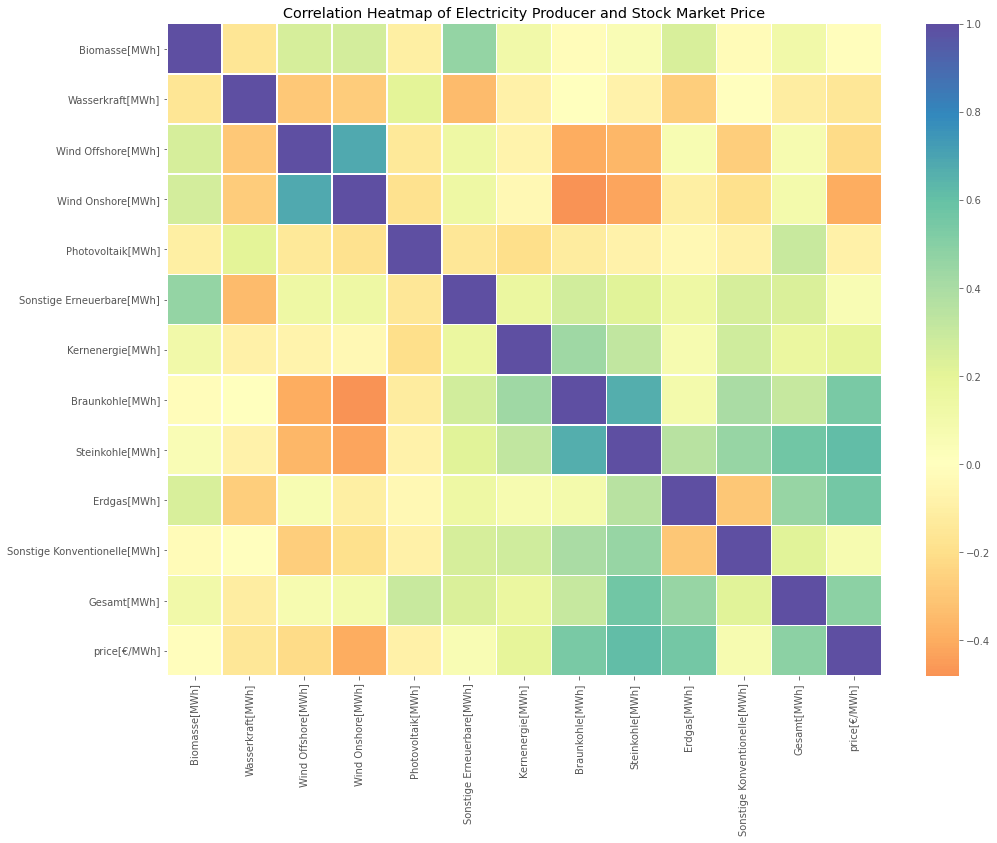

In [0]:
plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Electricity Producer and Stock Market Price')
ax = sns.heatmap(elec_sdp.corr(),center=0,linewidths=.5,  cmap="Spectral")
plt.show()

In [0]:
elec_sdp.to_csv('elec_sdp',index=False)